# Garbage Classification using PyTorch

Garbage segregation involves separating wastes according to how it's handled or processed. It's important for recycling as some materials are recyclable and others are not.


![Garbage Bins](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwebstockreview.net%2Fimages%2Fgarbage-clipart-wastebin-16.png&f=1&nofb=1)


In this notebook we'll use PyTorch for classifying trash into various categories like metal, cardboard, etc.

Let us start by importing the libraries:

In [43]:
# Import necessary libraries
import os  # For interacting with the operating system
import torch  # PyTorch library for deep learning
import torchvision  # Provides access to popular datasets, model architectures, and image transformations
from torch.utils.data import random_split  # For splitting datasets into train and validation sets
import torchvision.models as models  # Pre-trained models available in torchvision
import torch.nn as nn  # Neural network module in PyTorch
import torch.nn.functional as F  # Functional interface for operations on tensors

import matplotlib.pyplot as plt  # Matplotlib for plotting

# %matplotlib inline  # Magic command to display plots inline in Jupyter Notebook or IPython


Let us see the classes present in the dataset:

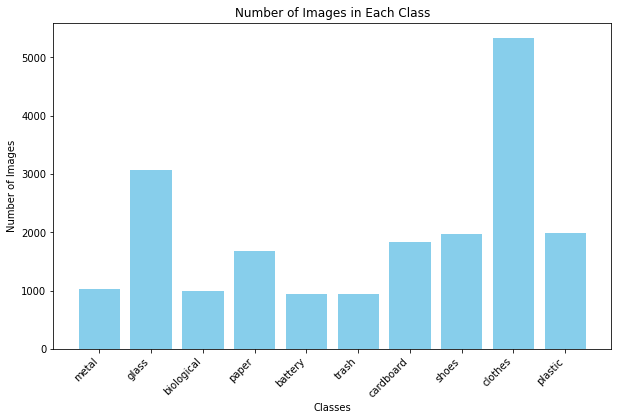

In [44]:
data_dir  = 'data/garbage-classification-v2/garbage-dataset'

classes = os.listdir(data_dir)
# Initialize a dictionary to store the count of images in each class
class_count = {}

# Loop through each class folder
for class_name in classes:
    # Count the number of images in the class folder
    class_count[class_name] = len(os.listdir(os.path.join(data_dir, class_name)))

# Plot the number of images in each class
plt.figure(figsize=(10, 6))
plt.bar(class_count.keys(), class_count.values(), color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.xticks(rotation=45, ha='right')
plt.show()

## Transformations:

Now, let's apply transformations to the dataset and import it for use.

In [45]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

Let's create a helper function to see the image and its corresponding label:

In [46]:


def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: battery (Class No: 0)


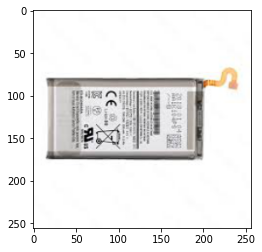

In [47]:
img, label = dataset[12]
show_sample(img, label)

# Loading and Splitting Data:

In [48]:
random_seed = 42
torch.manual_seed(random_seed)

We'll split the dataset into training, validation and test sets:

In [49]:
len(dataset)
#  8495 , 

19762

In [50]:
train_ds, test_ds = random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])
train_ds, val_ds = random_split(train_ds, [int(0.8 * len(train_ds)), len(train_ds) - int(0.8 * len(train_ds))])

In [51]:
print(len(train_ds), len(test_ds), len(val_ds))

12647 3953 3162


In [52]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

Now, we'll create training and validation dataloaders using `DataLoader`.

In [53]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

This is a helper function to visualize batches:

In [54]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

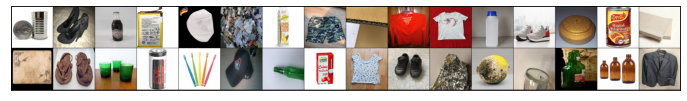

In [55]:
show_batch(train_dl)

# Model Base:

Let's create the model base:

In [56]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

We'll be using ResNet50 for classifying images:

In [57]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

## Porting to GPU:

GPUs tend to perform faster calculations than CPU. Let's take this advantage and use GPU for computation:

In [58]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [59]:
device = get_default_device()
device

device(type='cuda')

In [60]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

# Training the Model:

This is the function for fitting the model.

In [61]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

import time
import torch

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)

    # ------- Total training start -------
    total_start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()   # <-- epoch start

        # ---------------- Training Phase ----------------
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # ---------------- Validation Phase ----------------
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        history.append(result)

        # Print epoch summary
        model.epoch_end(epoch, result)

        # ------- Epoch time -------
        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time
        print(f"Epoch {epoch+1} finished in {epoch_time:.2f} sec")

    # ------- Total training end -------
    total_end_time = time.time()
    total_time = total_end_time - total_start_time

    minutes = int(total_time // 60)
    seconds = int(total_time % 60)

    print("\n======================")
    print(f"Total Training Time: {minutes} min {seconds} sec")
    print("======================\n")

    return history


In [62]:
model = to_device(ResNet(), device)

In [63]:
evaluate(model, val_dl)

{'val_loss': 2.300184965133667, 'val_acc': 0.0706009641289711}

Let's start training the model:

In [64]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Epoch 2: train_loss: 1.5050, val_loss: 1.5079, val_acc: 0.9425
Epoch 2 finished in 100.84 sec
Epoch 3: train_loss: 1.4876, val_loss: 1.5030, val_acc: 0.9555
Epoch 3 finished in 101.09 sec
Epoch 4: train_loss: 1.4801, val_loss: 1.4989, val_acc: 0.9575
Epoch 4 finished in 100.98 sec
Epoch 5: train_loss: 1.4742, val_loss: 1.5037, val_acc: 0.9505
Epoch 5 finished in 100.82 sec
Epoch 6: train_loss: 1.4731, val_loss: 1.4963, val_acc: 0.9599
Epoch 6 finished in 100.90 sec
Epoch 7: train_loss: 1.4706, val_loss: 1.4998, val_acc: 0.9567
Epoch 7 finished in 100.92 sec
Epoch 8: train_loss: 1.4694, val_loss: 1.5114, val_acc: 0.9416
Epoch 8 finished in 100.94 sec
Epoch 9: train_loss: 1.4704, val_loss: 1.5038, val_acc: 0.9511
Epoch 9 finished in 100.81 sec
Epoch 10: train_loss: 1.4698, val_loss: 1.5033, val_acc: 0.9500
Epoch 10 finished in 100.90 sec

Total Training Time: 16 min 49 sec



In [65]:
import matplotlib.pyplot as plt

def plot_accuracies(history):
    # 训练 accuracy 不存在，所以只画 val_acc
    val_acc = [x['val_acc'] for x in history]

    plt.subplot(1, 2, 1)
    plt.plot(val_acc, label='Validation Accuracy', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)


def plot_losses(history):
    train_loss = [x['train_loss'] for x in history]
    val_loss   = [x['val_loss'] for x in history]

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss', marker='o')
    plt.plot(val_loss, label='Validation Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)




In [66]:
history[0]

{'val_loss': 1.5119737386703491,
 'val_acc': 0.9472355842590332,
 'train_loss': 1.6159626245498657}

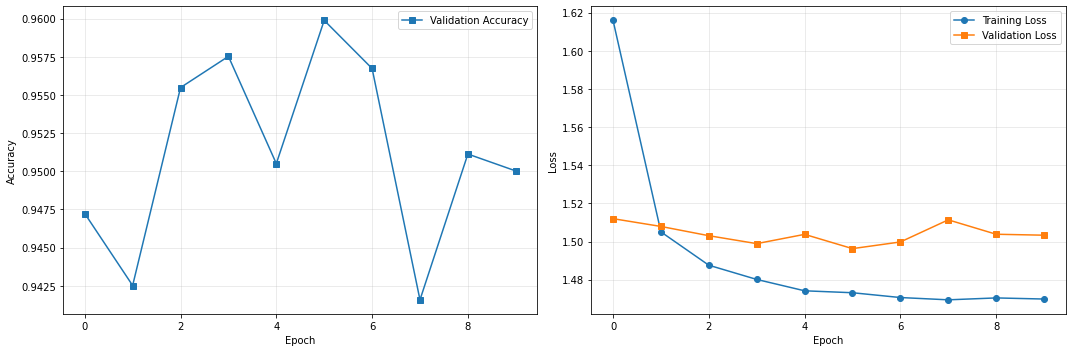

In [67]:
# ---- call plotting ----
plt.figure(figsize=(15, 5))
plot_accuracies(history)
plot_losses(history)
plt.tight_layout()
plt.show()


# Visualizing Predictions:

In [108]:


def predict_image(img, model):
    start_time = time.time()

    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)

    end_time = time.time()
    elapsed = end_time - start_time

    print(f"Prediction time: {elapsed:.4f} seconds")

    # Retrieve the class label
    return dataset.classes[preds[0].item()]


Let us see the model's predictions on the test dataset:

Prediction time: 0.0059 seconds
Label: trash , Predicted: trash


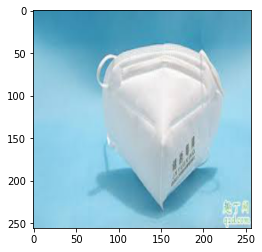

In [109]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Prediction time: 0.0056 seconds
Label: glass , Predicted: glass


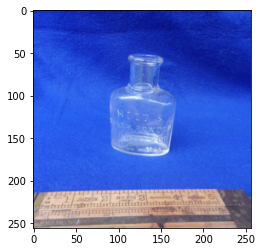

In [110]:
img, label = test_ds[23]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Prediction time: 0.0056 seconds
Label: shoes , Predicted: shoes


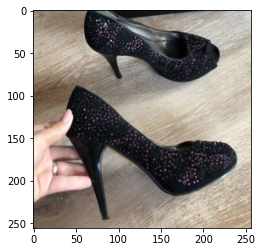

In [111]:
img, label = test_ds[51]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [115]:
import time
def predict_image_without_time(img, model):
    start_time = time.time()

    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)

    end_time = time.time()
    elapsed = end_time - start_time

    # Retrieve the class label
    return dataset.classes[preds[0].item()]
def test_model_accuracy(model, test_ds, num_samples=200):
    correct = 0
    total_time = 0.0

    # 防止 num_samples 比测试集长度还大
    num_samples = min(num_samples, len(test_ds))

    for i in range(num_samples):
        img, label_idx = test_ds[i]
        true_label = dataset.classes[label_idx]  # 真实类别名

        start_time = time.time()
        pred_label = predict_image_without_time(img, model)   # 这里还是只返回一个值
        elapsed = time.time() - start_time

        total_time += elapsed

        if pred_label == true_label:
            correct += 1

    accuracy = correct / num_samples * 100

    print(f"Tested {num_samples} images")
    print(f"Correct: {correct}")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Total prediction time: {total_time:.4f} seconds")
test_model_accuracy(model, test_ds, num_samples=200)


Tested 200 images
Correct: 194
Accuracy: 97.00%
Total prediction time: 2.8334 seconds


# Predicting External Images:

Let's now test with external images.

I'll use `urllib` for downloading external images.

In [72]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sumn2u/ml_rest_api/master/test-images/plastic.jpeg", "plastic.jpg")
urllib.request.urlretrieve("https://raw.githubusercontent.com/sumn2u/ml_rest_api/master/test-images/carboard.jpeg", "cardboard.jpg")    
urllib.request.urlretrieve("https://raw.githubusercontent.com/sumn2u/ml_rest_api/master/test-images/cans.jpeg", "cans.jpg") 
urllib.request.urlretrieve("https://raw.githubusercontent.com/sumn2u/ml_rest_api/master/test-images/wine.jpeg", "wine-trash.jpg")
urllib.request.urlretrieve("https://raw.githubusercontent.com/sumn2u/ml_rest_api/master/test-images/paper.jpeg", "paper-trash.jpg")

('paper-trash.jpg', <http.client.HTTPMessage at 0x7a2fe1d424d0>)

In [73]:
loaded_model = model

In [119]:
from PIL import Image
from pathlib import Path

def predict_external_image(image_name):
    image = Image.open(Path('./' + image_name))

    example_image = transformations(image)
    plt.imshow(example_image.permute(1, 2, 0))
    print("The image resembles", predict_image(example_image, loaded_model) + ".")


Prediction time: 0.0087 seconds
The image resembles metal.


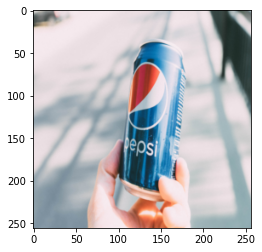

In [120]:
predict_external_image('cans.jpg')

Prediction time: 0.0085 seconds
The image resembles glass.


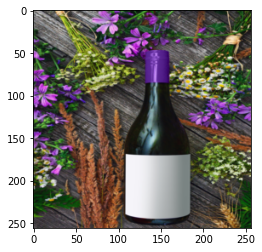

In [121]:
predict_external_image('wine-trash.jpg')

Prediction time: 0.0085 seconds
The image resembles paper.


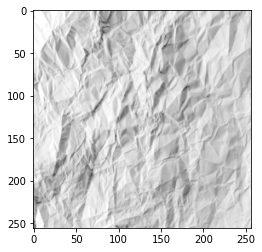

In [122]:
predict_external_image('paper-trash.jpg')

In [78]:
torch.save(model, '/kaggle/working/final_model.pt')

# Mobile Usage:
Save model for mobile usage.

In [79]:
# script = model.to_torchscript()
# torch.jit.save(script,'/kaggle/working/final_mobile_model.t7')
# compiled_model = torch.jit.script(model)
# torch.jit.save(compiled_model, '/kaggle/working/final_mobile_model.pt')

In [80]:
# model.eval()
# example = torch.rand(1, 3, 224, 224)
# traced_script_module = torch.jit.trace(model, example)
# traced_script_module.save("/kaggle/working/traced_resnet_model.pt")

In [81]:
example_input = torch.rand(1, 3, 224, 224, dtype=torch.float)
example_input = example_input.to(device)
# model = torch.jit.trace(model, example_input, check_trace=True, check_tolerance=1e-05, optimize=False,)

In [82]:
model = torch.jit.trace(model, example_input, check_trace=True, check_tolerance=1e-05)


In [83]:
torch.jit.save(model, "/kaggle/working/traced_resnet_model.pt")

In [84]:
loaded_compiled_model = torch.jit.load('/kaggle/working/traced_resnet_model.pt')
loaded_compiled_model.eval()

RecursiveScriptModule(
  original_name=ResNet
  (network): RecursiveScriptModule(
    original_name=ResNet
    (conv1): RecursiveScriptModule(original_name=Conv2d)
    (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
    (relu): RecursiveScriptModule(original_name=ReLU)
    (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
    (layer1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(
        original_name=Bottleneck
        (conv1): RecursiveScriptModule(original_name=Conv2d)
        (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
        (conv2): RecursiveScriptModule(original_name=Conv2d)
        (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
        (conv3): RecursiveScriptModule(original_name=Conv2d)
        (bn3): RecursiveScriptModule(original_name=BatchNorm2d)
        (relu): RecursiveScriptModule(original_name=ReLU)
        (downsample): RecursiveScriptModule(
          original_name=Sequential
          (0